# Evaluating impacts and mitigation strategies of missing abstracts

In this analysis we aim to understand the impact of missing abstracts and our mitigation attempts by adding missing abstracts.
We do so by picking a random sample of 1M works and trying to retrieve abstracts for those

In [2]:
import gzip
import logging
from pathlib import Path


import httpx
import numpy as np
import pandas as pd
import orjson as json
from tqdm import tqdm
from matplotlib import pyplot as plt

logging.basicConfig(format='%(asctime)s [%(levelname)s] %(name)s (%(process)d): %(message)s', level=logging.INFO)
logging.getLogger('httpx').setLevel(logging.WARNING)
logger = logging.getLogger('analysis')
logger.setLevel(logging.DEBUG)

## Setup

In [8]:
fp_snapshot = Path('/mnt/bulk/openalex/openalex-snapshot')
fp_target = Path('/mnt/bulk/openalex/oa_ids.txt')
fp_sample = Path('/mnt/bulk/openalex/oa_ids_sample.txt')
fp_infos = Path('/mnt/bulk/openalex/oa_sample.csv')
oa_base = 'http://localhost:8983/solr/openalex'

## 1) Prepare list of OpenAlex IDs

In [5]:
if fp_target.exists():
    raise Exception('File already exists, delete first if you really want to rebuild the ID list for 8h')

partitions = list(sorted(fp_snapshot.glob(f'data/works/**/*.gz')))
logger.info(f'Looks like there are {len(partitions):,} partitions.')

progress = tqdm.tqdm(total=len(partitions))

n_total = 0
n_failed = 0
with open(fp_target, 'w') as f_out:
    for pi, partition in enumerate(partitions, 1):
        progress.set_postfix_str(
            f'total={n_total:,}, '
            f'failed={n_failed:,}, '
            f'filesize={partition.stat().st_size / 1024 / 1024 / 1024:,.2f}GB, '
            f'partition={"/".join(partition.parts[-2:])}',
        )

        with gzip.open(partition, 'rb') as f_in:
            progress.set_description_str(f'READ ({pi:,})')
            ids = [json.loads(line).get('id','')[len('https://openalex.org/'):] for line in f_in]
            f_out.write('\n'.join(ids) + '\n')
        progress.update()

Exception: File already exists, delete first if you really want to rebuild the ID list for 8h

## 2) Select random sample

See [shuf manpage](https://www.gnu.org/software/coreutils/manual/html_node/shuf-invocation.html)

```
% cat oa_ids.txt | wc -l
463042077

% ll oa_ids.txt
239217975 5,2G -rw-rw-r-- 1 rept rept 5,2G Dez 17 01:48 oa_ids.txt
```

In [ ]:
%%bash
shuf -n 1000000 oa_ids.txt > oa_ids_sample.txt

## 3) Load extra info for samples

In [7]:
res.text

'<p>\n  Searching for Solr?<br/>\n  You must type the correct path.<br/>\n  Solr will respond.\n</p>\n'

In [11]:
def batched(iterable, bs: int):
    queue = []
    for it in iterable:
        queue.append(it)
        if len(queue) > bs:
            yield queue
            queue = []
    yield queue

if  fp_infos.exists():
    _bs=50
    infos = []
    missed = []
    with open(fp_sample) as f_in:
        for batch in tqdm(batched(f_in, _bs), total=10000/_bs):
            res = httpx.get(
                f'{oa_base}/select',
                params={
                    'df': 'id',
                    'fl': 'id,doi,publication_year,created_date,is_xpac,is_retracted,is_open_access,publisher,source,abstract_source',
                    'q.op': 'OR',
                    'rows': _bs,
                    'q': ' '.join([bi.strip() for bi in batch]),
                },
                timeout=120,
            )
            docs = res.json().get('response', {}).get('docs', [])
            missed.append(_bs - len(docs))
            infos += docs
    pd.DataFrame(infos).to_csv(fp_infos, index=False)
    print(sum(missed))
df = pd.read_csv(fp_infos)

 98%|█████████▊| 197/200.0 [00:47<00:00,  4.17it/s]


In [14]:
pd.DataFrame(infos).to_csv(fp_infos, index=False)

In [53]:
def batched(iterable, bs: int):
    queue = []
    for it in iterable:
        queue.append(it)
        if len(queue) >= bs:
            yield queue
            queue = []
    yield queue

if not fp_infos.exists():
    _bs=25
    infos = []
    missed = []
    with open(fp_sample) as f_in:
        for batch in tqdm(batched(f_in, _bs), total=10000/_bs):
            res = httpx.get(
                f'https://api.openalex.org/works',
                params={
                    'filter': 'ids.openalex:'+'|'.join([bi.strip() for bi in batch]),
                    'select': 'id,doi,publication_year,created_date,is_xpac,is_retracted',
                    'include_xpac': 'true',
                },
                timeout=120,
            )
            docs = res.json().get('results', [])
            infos += docs
            missed.append(_bs - len(docs))

    pd.DataFrame(infos).to_csv(fp_infos, index=False)

df = pd.read_csv(fp_infos)

401it [01:52,  3.57it/s]                           


In [52]:
a = set([bi.strip() for bi in batch])
b = set([ri['id'][len('https://openalex.org/'):] for ri in res.json()['results']])
print(len(a))
print(len(b))
print(a-b)
print(b-a)

25
25
set()
set()


In [55]:
df['publication_year'] = df['publication_year'].astype('Int16')

In [56]:
print(df.shape)
df.head()

(9995, 6)


,id,doi,publication_year,created_date,is_xpac,is_retracted
0,https://openalex.org/W1579813898,NaN,2003,2025-10-10T00:00:00,False,False
1,https://openalex.org/W1968106336,https://doi.org/10.1109/tbme.2015.2412136,2015,2025-10-10T00:00:00,False,False
2,https://openalex.org/W2059654618,https://doi.org/10.1007/s13738-012-0190-4,2012,2025-10-10T00:00:00,False,False
3,https://openalex.org/W2330132892,https://doi.org/10.1142/9789814324700_0104,2010,2025-10-10T00:00:00,False,False
4,https://openalex.org/W108797795,NaN,1971,2025-10-10T00:00:00,False,False


## Overview

In [57]:
urls = {
    'Total': 'https://api.openalex.org/works?group_by=publication_year&per_page=200&include_xpac=false&filter=publication_year:1900-2025',
    'Has abstract': 'https://api.openalex.org/works?group_by=publication_year&per_page=200&include_xpac=false&filter=publication_year:1990-2025,has_abstract:true',
    'Total (xpac)': 'https://api.openalex.org/works?group_by=publication_year&per_page=200&include_xpac=true&filter=publication_year:1900-2025',
    'Has abstract (xpac)': 'https://api.openalex.org/works?group_by=publication_year&per_page=200&include_xpac=true&filter=publication_year:1990-2025,has_abstract:true',
}
df_total = pd.concat([
     pd.DataFrame([{'PY': int(grp['key']), key: int(grp['count'])} for grp in httpx.get(url).json().get('group_by')]).set_index('PY')
    for key, url in urls.items()
], axis=1).fillna(0).astype(int)
print(df_total.shape)
df_total.head()

(126, 4)


,Total,Has abstract,Total (xpac),Has abstract (xpac)
PY,,,,
2025,13462014,7135480,44449318,29935751
2020,11095544,7781599,16336342,10656156
2019,10361086,7101821,16613634,10770733
2023,10285800,8028205,21792729,12156421
2016,10175697,6283062,16910372,10211238


In [58]:
n_total = df.shape[0]
print(f'Total: {n_total:,}')
for field in ['is_xpac', 'is_retracted', 'is_open_access']:
    n = df[field].sum()
    print(    f'{field} == true: {n:,} ({n/n_total:.2%}; Ñ={n_total-n:,})')
for field in ['abstract_source', 'publication_year', 'doi', 'created_date', 'publisher', 'source']:
    n = df[field].notna().sum()
    print(f'{field} is not None: {n:,} ({n/n_total:.2%}; Ñ={n_total-n:,})')

Total: 9,995
is_xpac == true: 4,260 (42.62%; Ñ=5,735)
is_retracted == true: 3 (0.03%; Ñ=9,992)


KeyError: 'is_open_access'

,Total (sample),Total,Has abstract,Total (xpac),Has abstract (xpac)
PY,,,,,
1990,51,2005322,1048231,2459319,1176664
1991,55,2007375,1093639,2432779,1230478
1992,56,2092523,1147405,2567363,1305609
1993,64,2188708,1200716,2658931,1363434
1994,65,2306779,1278738,2802914,1430544
1995,66,2446606,1350523,2997480,1517034
1996,90,2650550,1421723,3218106,1607719
1997,76,2747347,1468404,3285333,1635978
1998,83,2927582,1558518,3498555,1742134


<Axes: xlabel='PY'>

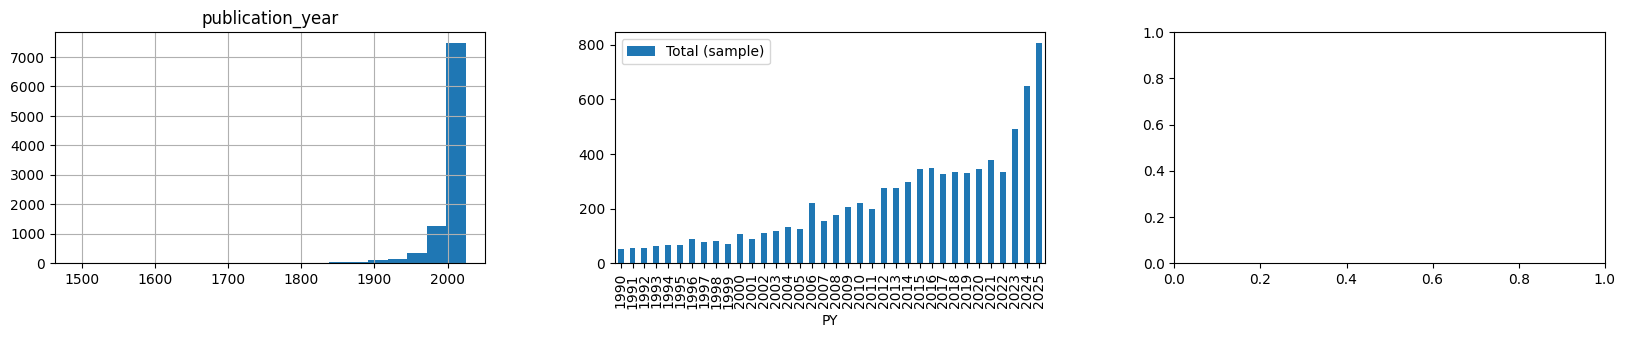

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(20, 3))

df.hist('publication_year', ax=axes[0], bins=20)

cnt_total, years = np.histogram(df[df['publication_year'].notna()]['publication_year'], range=(1990, 2026), bins=36)
#cnt_abs, years = np.histogram(df[df['publication_year'].notna() & df['abstract_source'].isna()]['publication_year'], range=(1990, 2026), bins=36)

df_hist = pd.DataFrame({
    'PY': years[:-1].astype(int),
    'Total (sample)': cnt_total,
 #   'Has abstract (sample)': cnt_abs,
  #  'ratio': cnt_abs / cnt_total * 100,
}).set_index('PY').join(df_total)
display(df_hist)

df_hist.plot.bar(y='Total (sample)', ax=axes[1])
#sec = axes[1].twinx()
#sec.plot(np.arange(36), df_hist['ratio'], lw=1, c='grey')
#df_hist.plot.bar(y='Has abstract (sample)', ax=axes[2])


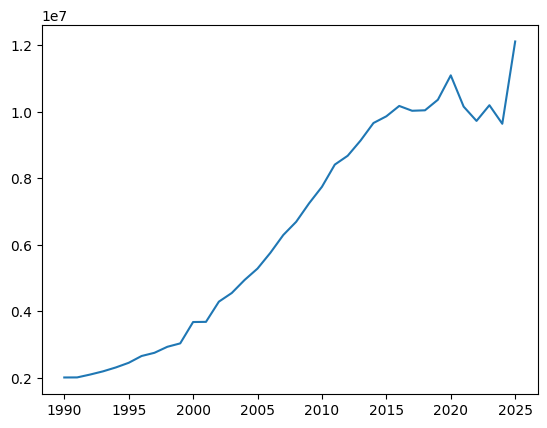

In [108]:
plt.plot(df_hist['Total'])

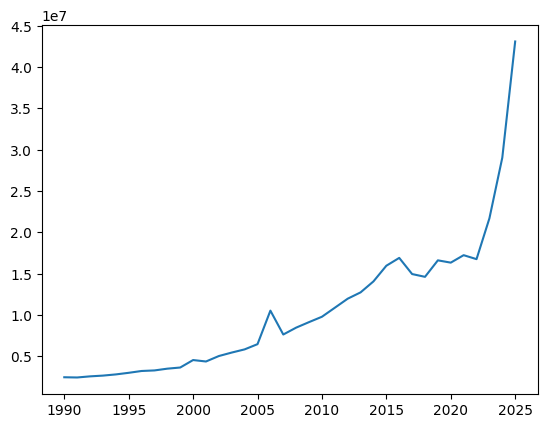

In [105]:
plt.plot(df_hist['Total (xpac)'])

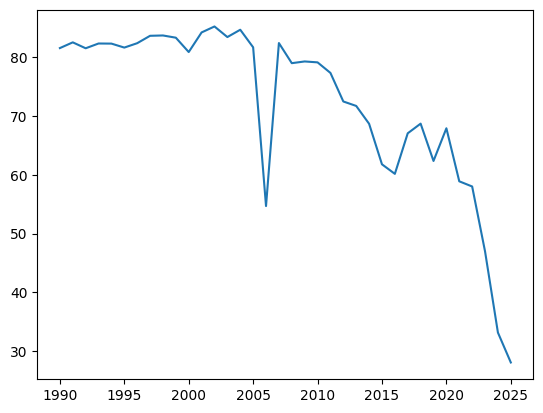

In [107]:
plt.plot(df_hist['Total'] / df_hist['Total (xpac)'] * 100)

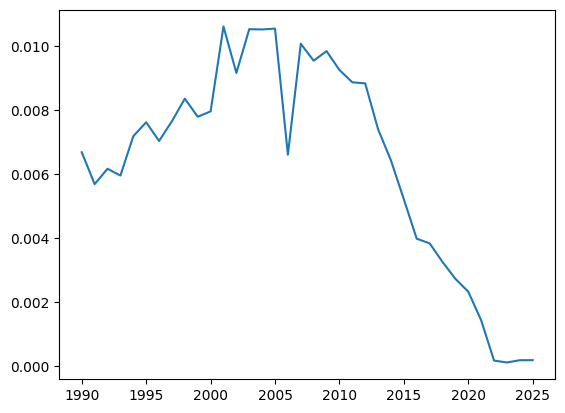

In [106]:
plt.plot(df_hist['Total (sample)'] / df_hist['Total (xpac)'] * 100)